In [1]:
import numpy as np
np.warnings.simplefilter("ignore")
# MultiLayerNetExtendにwarningがあったので消す
% matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# 確率的勾配降下法
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [3]:
# 慣性の概念を取り入れる
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

In [4]:
# 学習係数を減衰させる
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [5]:
# momentumとadagradを融合
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

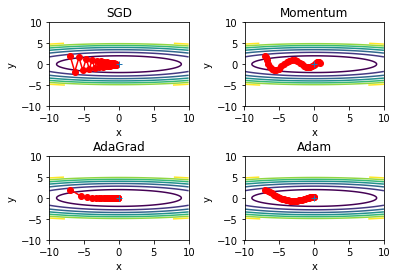

In [6]:
# 2変数の二次関数でプロットしてみる
from collections import OrderedDict


def f(x, y):
    return (x**2 / 20.0) + y**2


def df(x, y):
    return x / 10.0, 2.0*y

# 初期値
init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

# 比較する最適化手法
optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        # xとyについてそれぞれ偏微分
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")

plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

In [7]:
# それぞれの最適化法を損失関数を観察して検証する
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 検証する最適化手法
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()

networks = {}
train_loss = {}

for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 訓練する
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    # 損失関数の値を出力
    if i % 500 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

===========iteration:0===========
AdaGrad:1.8798363021406868
SGD:2.3410918664986795
Adam:2.2248757691373173
Momentum:2.358544377675507
===========iteration:500===========
AdaGrad:0.08032113217607001
SGD:0.4346350667771335
Adam:0.18606893794170346
Momentum:0.20142156469899286
===========iteration:1000===========
AdaGrad:0.042441735571897184
SGD:0.380100318726863
Adam:0.062457904413320664
Momentum:0.09061833127162901
===========iteration:1500===========
AdaGrad:0.04456842409478236
SGD:0.21141840145491725
Adam:0.0668655172348322
Momentum:0.11806458720476808


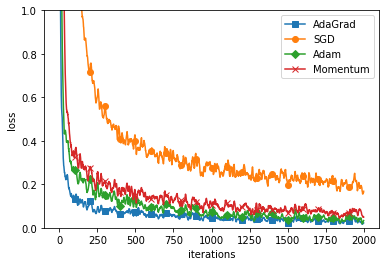

In [8]:
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

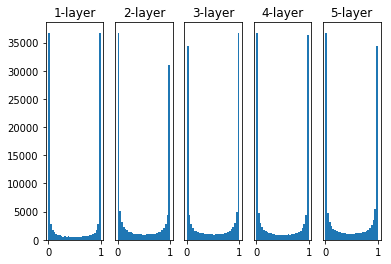

In [9]:
# 入力をニューラルネットに流してsigmoidでアクティベーションした結果について、各層で分布を観察
# 重みの標準偏差を小さくすると値が1と0付近(つまりsigmoidへの入力の絶対値が大きい)ことがわかる
# バックプロパゲートしようとした時に1と0付近のsigmoidの微分の値を何回も掛けてしまうことで勾配が極めて小さくなってしまう
# 重みの分散が大きいと端の学習が全くすすまない勾配消失がおこる
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 入力は正規分布する要素100個からなるサンプル1000個
x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    # 重みの標準偏差を1にする
    w = np.random.randn(node_num, node_num) * 1
    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a
    
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    # y軸の目盛りを消す
    if i != 0:
        plt.yticks([], [])
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()

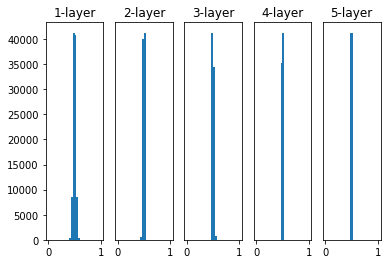

In [10]:
# 重みの標準偏差を小さくすると値が0.5付近(つまりsigmoidへの入力が0付近になる)ことがわかる
# これはこれで、複数の重みがほぼ同じ値になってしまうので、重みを複数持つ意味がなくなってしまう
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    # 重みの標準偏差を0.01にする
    w = np.random.randn(node_num, node_num) * 0.01
    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a
    
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    if i != 0:
        plt.yticks([], [])
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()

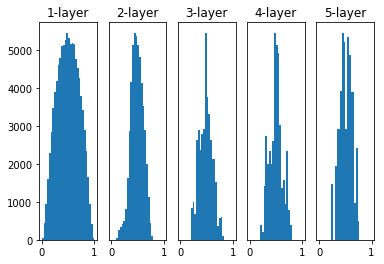

In [11]:
# Xavierの初期値
# ディープラーニングのフレームワークで標準的に使われる手法
# 前層のノードの個数をnとしたとき、sqrt(1/n) の標準偏差を持つガウス分布として重みの初期値を設定する
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a
    
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    if i != 0:
        plt.yticks([], [])
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()

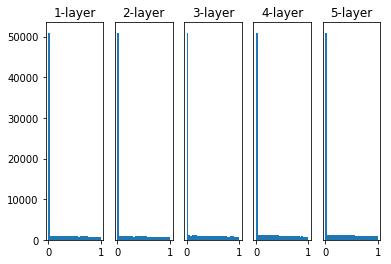

In [12]:
# Heの初期値
# reluで活性させるときに使う
# 前層のノードの個数をnとしたとき、sqrt(2/n) の標準偏差を持つガウス分布として重みの初期値を設定する
def relu(x):
    return np.maximum(0, x)

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num/2)
    z = np.dot(x, w)
    a = relu(z)
    activations[i] = a

# Heの初期値を使うとreluを使っても分布が均一になる(単純なガウス分布やXavierの初期値では偏る)
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    if i != 0:
        plt.yticks([], [])
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()

In [13]:
# それぞれの重みの初期化方法を比較する
# アクティベーションにはreluを使用
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 検証する最適化手法
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)


networks = {}
train_loss = {}

for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(
        input_size=784,
        hidden_size_list=[100, 100, 100, 100],
        output_size=10,
        weight_init_std=weight_type
    )
    train_loss[key] = []

# 訓練する
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    # 損失関数の値を出力
    if i % 500 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

===========iteration:0===========
He:2.4230129693324742
Xavier:2.2882202542448944
std=0.01:2.3025228083443188
===========iteration:500===========
He:0.374728036058437
Xavier:0.7654965839514238
std=0.01:2.302758581938317
===========iteration:1000===========
He:0.2808157995488782
Xavier:0.4081928508154946
std=0.01:2.2998147781304485
===========iteration:1500===========
He:0.20966593287543228
Xavier:0.2799652562249419
std=0.01:2.299440359243699


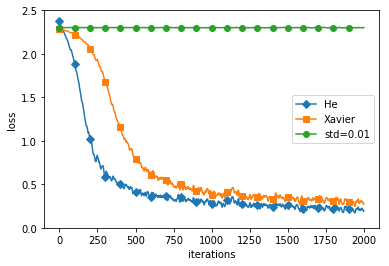

In [14]:
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

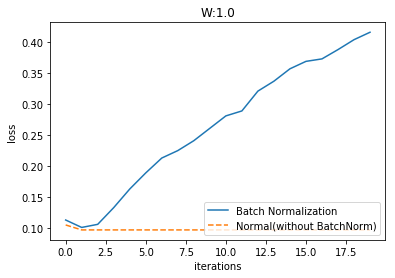

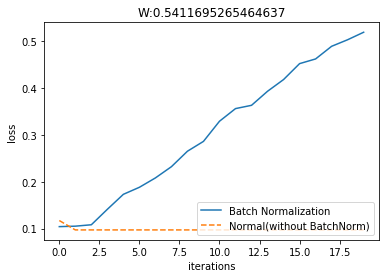

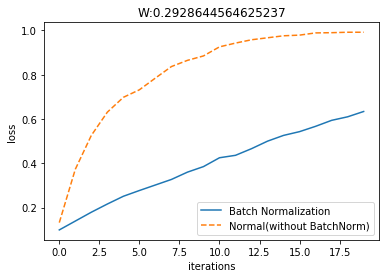

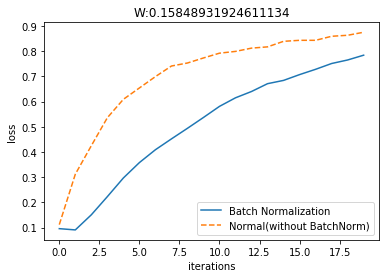

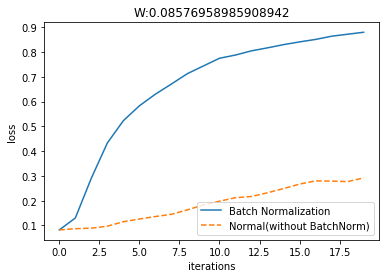

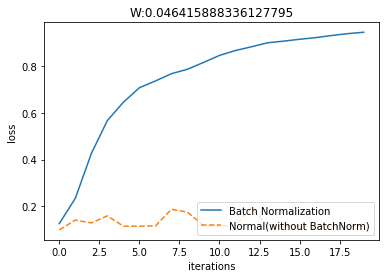

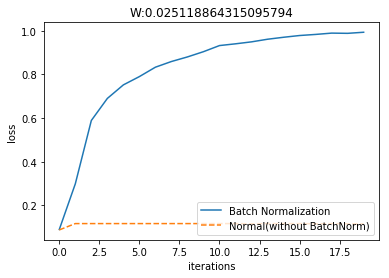

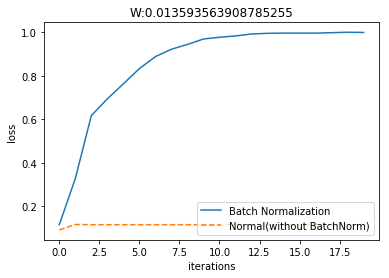

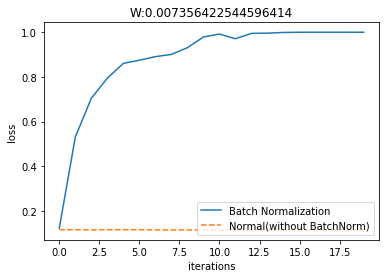

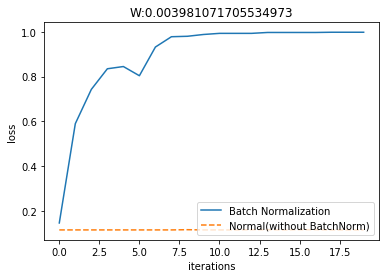

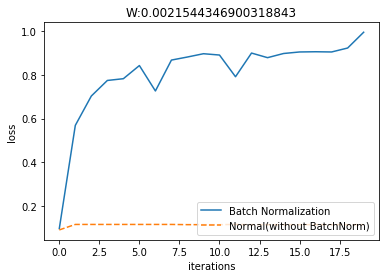

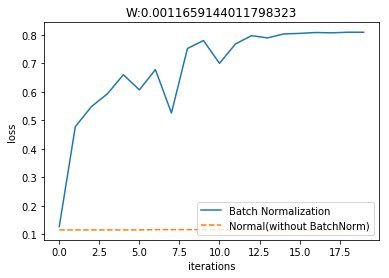

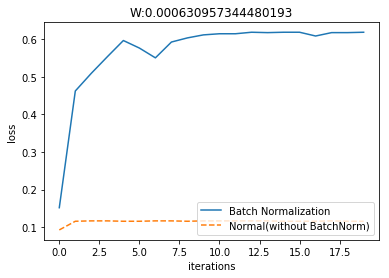

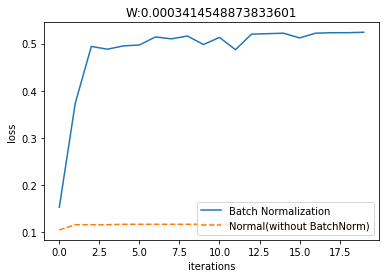

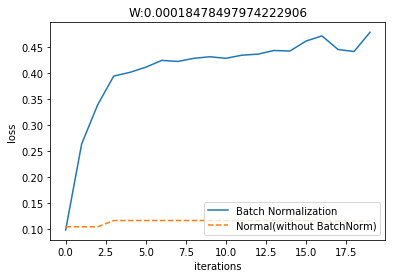

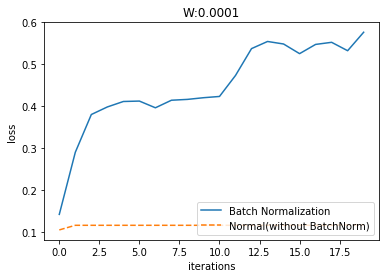

In [15]:
# batch normalization: 入力層からデータを無作為抽出してそこから標準偏差と平均をだして入力の分布をノーマライズする
# どの重みの初期値であってもbatch normalizationの学習速度が良いことを確認する
from common.multi_layer_net_extend import MultiLayerNetExtend

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    # batch_normalizationするネットワーク
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    # batch_normalizationしないネットワーク
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        # 無作為抽出してミニバッチ学習
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list

# グラフ描画
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    train_acc_list, bn_train_acc_list = __train(w)
    plt.title("W:" + str(w))
    plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
    plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    plt.xlabel("iterations")
    plt.ylabel("loss")
    plt.legend(loc='lower right')
    plt.show()

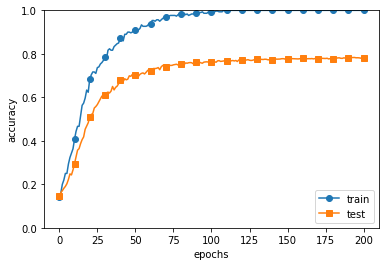

In [16]:
# 過学習してしまっているネットワークの例
# 訓練データとテストデータの精度に乖離が生じている
from common.optimizer import SGD
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# 過学習するネットワーク
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

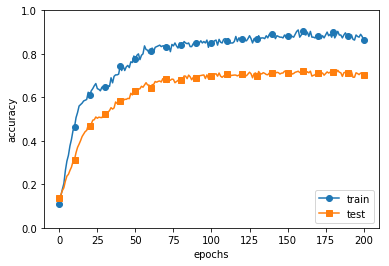

In [17]:
# 過学習を抑えるためにweight decayを導入する
from common.optimizer import SGD
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay またの名を L2正則化
weight_decay_lambda = 0.1

# weight decayするネットワーク
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

train loss:2.2583144650479627
=== epoch:1, train acc:0.11333333333333333, test acc:0.1015 ===
train loss:2.3277459262734834
train loss:2.2702197880678936
train loss:2.194855217482307
=== epoch:2, train acc:0.12333333333333334, test acc:0.1041 ===
train loss:2.21981138614262
train loss:2.2362082211997
train loss:2.204157170413239
=== epoch:3, train acc:0.12666666666666668, test acc:0.1066 ===
train loss:2.1757701551579034
train loss:2.2578734798047773
train loss:2.199002987820042
=== epoch:4, train acc:0.14333333333333334, test acc:0.1164 ===
train loss:2.236115163022425
train loss:2.170433216159913
train loss:2.17866512072717
=== epoch:5, train acc:0.16, test acc:0.1256 ===
train loss:2.150235110467097
train loss:2.173724105704913
train loss:2.112385929930915
=== epoch:6, train acc:0.20666666666666667, test acc:0.1438 ===
train loss:2.167090663742941
train loss:2.17165336007478
train loss:2.101575265339654
=== epoch:7, train acc:0.21666666666666667, test acc:0.1572 ===
train loss:2.086

=== epoch:56, train acc:0.92, test acc:0.693 ===
train loss:0.4124230678495314
train loss:0.47977495927606434
train loss:0.408118009688646
=== epoch:57, train acc:0.94, test acc:0.7024 ===
train loss:0.3496174517091795
train loss:0.3488602978164994
train loss:0.36959848776448523
=== epoch:58, train acc:0.9333333333333333, test acc:0.6981 ===
train loss:0.3167388747052981
train loss:0.41046919368233126
train loss:0.3691008306662067
=== epoch:59, train acc:0.93, test acc:0.6981 ===
train loss:0.39603527838108143
train loss:0.32884570854954903
train loss:0.3369572107377964
=== epoch:60, train acc:0.9366666666666666, test acc:0.695 ===
train loss:0.37669105642372913
train loss:0.34301335934238525
train loss:0.34258768658392696
=== epoch:61, train acc:0.93, test acc:0.6978 ===
train loss:0.365091791522495
train loss:0.3795027834759417
train loss:0.3019497769298569
=== epoch:62, train acc:0.95, test acc:0.7064 ===
train loss:0.2931267203583796
train loss:0.3061988803207375
train loss:0.25807

=== epoch:111, train acc:0.9966666666666667, test acc:0.7506 ===
train loss:0.06847772135175954
train loss:0.061208930020759104
train loss:0.07435485231465318
=== epoch:112, train acc:0.9966666666666667, test acc:0.7555 ===
train loss:0.08969848241175933
train loss:0.12109950626694871
train loss:0.07394814780968548
=== epoch:113, train acc:0.9966666666666667, test acc:0.7508 ===
train loss:0.07057668641518838
train loss:0.07500838510933382
train loss:0.05691914936118653
=== epoch:114, train acc:0.9966666666666667, test acc:0.7499 ===
train loss:0.0688106142676506
train loss:0.06791640185825425
train loss:0.04407867369970774
=== epoch:115, train acc:0.9966666666666667, test acc:0.7524 ===
train loss:0.06482944150204493
train loss:0.0761257787082989
train loss:0.07456357645957266
=== epoch:116, train acc:0.9966666666666667, test acc:0.7515 ===
train loss:0.06020204790318593
train loss:0.06551645004619185
train loss:0.053696239217967866
=== epoch:117, train acc:0.9966666666666667, test ac

=== epoch:167, train acc:1.0, test acc:0.7587 ===
train loss:0.0332069199191855
train loss:0.03180412435029904
train loss:0.027552468336049213
=== epoch:168, train acc:1.0, test acc:0.759 ===
train loss:0.0384816975040931
train loss:0.025616138799163624
train loss:0.026813593779959562
=== epoch:169, train acc:1.0, test acc:0.7617 ===
train loss:0.026382469673957507
train loss:0.02691543525665544
train loss:0.030128530725465095
=== epoch:170, train acc:1.0, test acc:0.7622 ===
train loss:0.02677968749865759
train loss:0.02801293242275306
train loss:0.03161354812907981
=== epoch:171, train acc:1.0, test acc:0.7637 ===
train loss:0.026746504836862223
train loss:0.03216220056969882
train loss:0.03344881145003847
=== epoch:172, train acc:1.0, test acc:0.7639 ===
train loss:0.02948630071345831
train loss:0.02376710577430233
train loss:0.029857562065679404
=== epoch:173, train acc:1.0, test acc:0.7642 ===
train loss:0.024135696782816508
train loss:0.026314477463692774
train loss:0.02437337903

=== epoch:224, train acc:1.0, test acc:0.766 ===
train loss:0.01641355036128763
train loss:0.01395138668535115
train loss:0.017006009745456182
=== epoch:225, train acc:1.0, test acc:0.7659 ===
train loss:0.02078403210596739
train loss:0.013097682243853158
train loss:0.013648776875912549
=== epoch:226, train acc:1.0, test acc:0.7655 ===
train loss:0.014714783314197748
train loss:0.014339363921914563
train loss:0.01350775250681087
=== epoch:227, train acc:1.0, test acc:0.7661 ===
train loss:0.010853811218418665
train loss:0.018290006229933344
train loss:0.01706363485521771
=== epoch:228, train acc:1.0, test acc:0.7657 ===
train loss:0.01727240123260375
train loss:0.017001777128975194
train loss:0.013557478284479778
=== epoch:229, train acc:1.0, test acc:0.7674 ===
train loss:0.01228021718416404
train loss:0.016375919570657434
train loss:0.013221640627957635
=== epoch:230, train acc:1.0, test acc:0.7673 ===
train loss:0.014813477054942792
train loss:0.01261170169648962
train loss:0.012724

=== epoch:281, train acc:1.0, test acc:0.7684 ===
train loss:0.00865243849661668
train loss:0.011968723380586077
train loss:0.008527641284204265
=== epoch:282, train acc:1.0, test acc:0.7667 ===
train loss:0.011862481088166302
train loss:0.007597577575464122
train loss:0.01052344533396317
=== epoch:283, train acc:1.0, test acc:0.7675 ===
train loss:0.01270781633867527
train loss:0.009210350375456946
train loss:0.009169771657459556
=== epoch:284, train acc:1.0, test acc:0.7679 ===
train loss:0.008843374725975043
train loss:0.010658055474518884
train loss:0.011200562452146063
=== epoch:285, train acc:1.0, test acc:0.7678 ===
train loss:0.011117378981898103
train loss:0.010108583989178162
train loss:0.009507408762131686
=== epoch:286, train acc:1.0, test acc:0.7679 ===
train loss:0.008853867663755954
train loss:0.009009516688545622
train loss:0.013049205452513703
=== epoch:287, train acc:1.0, test acc:0.7667 ===
train loss:0.008401170078341963
train loss:0.008323836679288012
train loss:0.

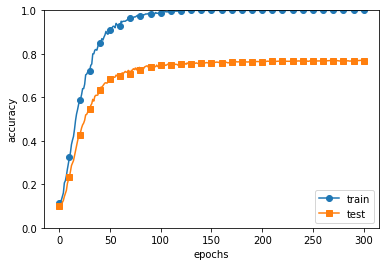

In [18]:
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

train loss:2.281164280377583
=== epoch:1, train acc:0.11333333333333333, test acc:0.1084 ===
train loss:2.2718413607845567
train loss:2.291026883886757
train loss:2.273763557720331
=== epoch:2, train acc:0.11666666666666667, test acc:0.111 ===
train loss:2.2840525447873095
train loss:2.2781606475540155
train loss:2.2722409438421476
=== epoch:3, train acc:0.11666666666666667, test acc:0.1156 ===
train loss:2.296499313653444
train loss:2.247625108409286
train loss:2.262477126903126
=== epoch:4, train acc:0.12, test acc:0.1157 ===
train loss:2.284355309875395
train loss:2.2828395500396486
train loss:2.2731655120251184
=== epoch:5, train acc:0.12, test acc:0.118 ===
train loss:2.2715545038272653
train loss:2.270502544795634
train loss:2.2776894918467487
=== epoch:6, train acc:0.12, test acc:0.1192 ===
train loss:2.274362155681869
train loss:2.270708489786742
train loss:2.2644012676861416
=== epoch:7, train acc:0.13, test acc:0.1236 ===
train loss:2.264875391940781
train loss:2.273676278074

=== epoch:57, train acc:0.37, test acc:0.2884 ===
train loss:2.203053161683999
train loss:2.216808566141964
train loss:2.1993570831977785
=== epoch:58, train acc:0.39, test acc:0.2944 ===
train loss:2.2200330423439416
train loss:2.203409791233723
train loss:2.2164994145546295
=== epoch:59, train acc:0.4033333333333333, test acc:0.3007 ===
train loss:2.211232218370512
train loss:2.203522559516103
train loss:2.1934009202316904
=== epoch:60, train acc:0.3933333333333333, test acc:0.2981 ===
train loss:2.227507694884219
train loss:2.231053738013418
train loss:2.2193202331134176
=== epoch:61, train acc:0.4066666666666667, test acc:0.3087 ===
train loss:2.2062587637149678
train loss:2.1906125288763927
train loss:2.191492559101891
=== epoch:62, train acc:0.4033333333333333, test acc:0.315 ===
train loss:2.1968212704361467
train loss:2.214707533005408
train loss:2.193744074678024
=== epoch:63, train acc:0.4, test acc:0.3168 ===
train loss:2.163650257548474
train loss:2.1802376709089066
train l

=== epoch:113, train acc:0.5133333333333333, test acc:0.4048 ===
train loss:2.0983211111368734
train loss:2.0534699549715345
train loss:2.0586780475655404
=== epoch:114, train acc:0.51, test acc:0.4047 ===
train loss:2.084821160168835
train loss:2.083543438840038
train loss:2.026502323233003
=== epoch:115, train acc:0.5166666666666667, test acc:0.405 ===
train loss:2.031272543136165
train loss:2.044195054250353
train loss:2.0016436827923534
=== epoch:116, train acc:0.5166666666666667, test acc:0.408 ===
train loss:2.086627762385211
train loss:2.0756295782318337
train loss:2.0193515014552195
=== epoch:117, train acc:0.52, test acc:0.4079 ===
train loss:2.060124007704992
train loss:2.0703999740676378
train loss:2.0279654096190507
=== epoch:118, train acc:0.53, test acc:0.412 ===
train loss:2.006802507281935
train loss:2.024124029942225
train loss:2.035193397904129
=== epoch:119, train acc:0.5233333333333333, test acc:0.4111 ===
train loss:2.0365390370175898
train loss:1.9864590211067266


=== epoch:168, train acc:0.5166666666666667, test acc:0.4461 ===
train loss:1.7953520745252773
train loss:1.750416888393733
train loss:1.7249486620692005
=== epoch:169, train acc:0.52, test acc:0.4476 ===
train loss:1.780099897200968
train loss:1.7726172470598884
train loss:1.7223571355447875
=== epoch:170, train acc:0.5233333333333333, test acc:0.45 ===
train loss:1.6685816145331136
train loss:1.7644183018123312
train loss:1.6609814783748251
=== epoch:171, train acc:0.5266666666666666, test acc:0.4528 ===
train loss:1.6241098436332093
train loss:1.720651713319366
train loss:1.7043311035251736
=== epoch:172, train acc:0.5266666666666666, test acc:0.454 ===
train loss:1.6548289637058757
train loss:1.7170355452152948
train loss:1.72467976704013
=== epoch:173, train acc:0.53, test acc:0.4539 ===
train loss:1.6184503454122126
train loss:1.795935709385468
train loss:1.8035471196737947
=== epoch:174, train acc:0.53, test acc:0.4571 ===
train loss:1.6683898723254316
train loss:1.6464927351706

=== epoch:224, train acc:0.63, test acc:0.5346 ===
train loss:1.292561775982866
train loss:1.3204093279403009
train loss:1.2507520723358383
=== epoch:225, train acc:0.65, test acc:0.5434 ===
train loss:1.3271239170362552
train loss:1.248391829406399
train loss:1.2418603815604685
=== epoch:226, train acc:0.6533333333333333, test acc:0.5436 ===
train loss:1.2231890009382935
train loss:1.2043931619464814
train loss:1.1440078082188263
=== epoch:227, train acc:0.6433333333333333, test acc:0.5442 ===
train loss:1.2718517949276218
train loss:1.3875113675110113
train loss:1.1136182758385138
=== epoch:228, train acc:0.6533333333333333, test acc:0.5472 ===
train loss:1.1520202265817068
train loss:1.272075374120261
train loss:1.155304696739159
=== epoch:229, train acc:0.6533333333333333, test acc:0.547 ===
train loss:1.2324877549062883
train loss:1.1897955613148197
train loss:1.0713218162944746
=== epoch:230, train acc:0.67, test acc:0.553 ===
train loss:1.3029450472643331
train loss:1.1390378254

=== epoch:279, train acc:0.75, test acc:0.6082 ===
train loss:0.9410711973904533
train loss:0.8403584267150294
train loss:0.8007972174755347
=== epoch:280, train acc:0.7466666666666667, test acc:0.6111 ===
train loss:0.9246326944313102
train loss:0.9397254951213841
train loss:0.8040670577700003
=== epoch:281, train acc:0.7433333333333333, test acc:0.6108 ===
train loss:0.9760853709644702
train loss:0.9998403843019242
train loss:0.8767362427734571
=== epoch:282, train acc:0.7433333333333333, test acc:0.6125 ===
train loss:0.8744775664584508
train loss:0.8438020252969787
train loss:0.8638909963981348
=== epoch:283, train acc:0.7466666666666667, test acc:0.6146 ===
train loss:0.8545591548200782
train loss:0.9038212078677508
train loss:0.8012177821952862
=== epoch:284, train acc:0.75, test acc:0.6116 ===
train loss:0.7676705260446526
train loss:0.7758984335458837
train loss:0.8484295001486473
=== epoch:285, train acc:0.7433333333333333, test acc:0.6155 ===
train loss:0.9300086964689865
tra

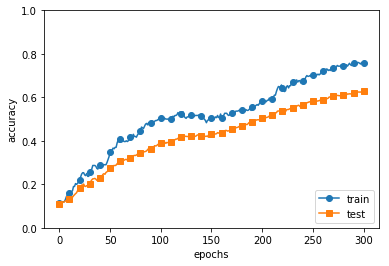

In [19]:
# dropoutでニューロンをランダムに消してアンサンブル学習する
# weight decayで対応できない複雑なネットワークモデルにも過学習対策できる
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# Dropuoutの有無、割り合いの設定 ========================
use_dropout = True  # Dropoutなしのときの場合はFalseに
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

Best-1(val acc:0.8) | lr:0.00957388253854171, weight decay:2.6136447276114392e-05
Best-2(val acc:0.79) | lr:0.009446257571910163, weight decay:1.6626294798077848e-08
Best-3(val acc:0.78) | lr:0.008625466167648858, weight decay:9.220027827116745e-08
Best-4(val acc:0.69) | lr:0.005793602811996612, weight decay:2.1984229034323926e-08
Best-5(val acc:0.68) | lr:0.00587843625560309, weight decay:3.1239992603934475e-07
Best-6(val acc:0.57) | lr:0.0033453511865638545, weight decay:3.708571149999862e-08
Best-7(val acc:0.57) | lr:0.0035391290518547876, weight decay:1.4702797839523944e-05
Best-8(val acc:0.52) | lr:0.0029264404532568906, weight decay:3.5968668262408905e-07
Best-9(val acc:0.5) | lr:0.002675117608664779, weight decay:3.168384087107017e-07
Best-10(val acc:0.49) | lr:0.0035016134522675296, weight decay:1.2064920782827262e-05
Best-11(val acc:0.46) | lr:0.0027067858884506973, weight decay:6.758405925958793e-07
Best-12(val acc:0.42) | lr:0.003478899230145606, weight decay:1.0353038282991

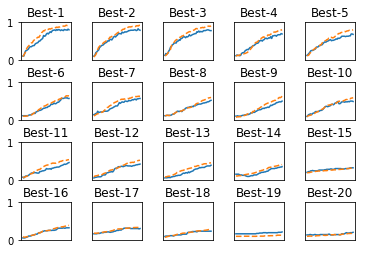

In [20]:
# 訓練データは重みやバイアスの学習に使う
# 検証データはハイパーパラメータの評価に使う
# テストデータは汎化性能をチェックするために使う
from common.util import shuffle_dataset

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 検証データの分離
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# ハイパーパラメータのランダム探索
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 探索したハイパーパラメータの範囲を指定
    # weight decayを10**-8から10**-4までを探索 
    weight_decay = 10 ** np.random.uniform(-8, -4)
    # lrを10**-6から10**-2
    lr = 10 ** np.random.uniform(-6, -2)

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# グラフの描画
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

# 精度の高い順にソートして結果をそれぞれ出力
for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)
    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()